# Automated change detection and severity mapping using Digital Earth Australia - Worked example including technical details

This script shows the workflow for change detection and severity mapping using the DEA Landsat data archive and the burn mapping tools developed by ANU. Contrary to the script 'Simple Case Example" this notebook provides further details on the underlying concepts and theory.

## Retrieve imagery from the DEA

To illustrate the concepts used in this toolbox, we first need to load in a time series of Landsat imagery.
To that end, we'll import the 'BurnCube' and use the 'load_cube' module, and use it to extracts Landsat data from the DEA and masks out cloud pixels.

In [1]:
%matplotlib inline
from BurnCube import BurnCube #including burn mapping main functions
bc = BurnCube()

import pyproj
lon =  144.854834
lat = -41.144223

wgs84 = pyproj.Proj(init='epsg:4326')
gda94 = pyproj.Proj(init='epsg:3577')

easting,northing = pyproj.transform(wgs84,gda94,lon,lat) # covert latitude and longitude to easting and northing 

x = (easting+12500,easting-12500) # 25km tile
y = (northing+12500,northing-12500)
res = (25, 25)
sensor = [8]

datatime = ('2013-01-01','2018-12-31') # period for extracting landsat data
period = ('2013-01-01','2017-12-31') # period used for the calculation of geometric median, the "period" normally is from the Landsate 8 start to the year before fire)
mappingperiod = ('2018-01-01','2018-12-31') #period for burn mapping

Loading data from the datacube uses the loaddea function. Dates with less than 20% good-quality pixels for the region of interest will be ignored.

The function takes several arguments:
    
    x; Defines the spatial region in the x dimension (easting, EPSG 3577)
    y; Defines the spatial region in the y dimension (northing, EPSG 3577)
    time; Defines the temporal extent
    resolution; Defines the spatial resolution
    landsat_numbers; Defines the numbers of Landsat in the list format, e.g. [5,7,8] or [8]

The standard projection is EPSG:3577 (GDA94 / Australian Albers), the latitude and longitude can be converted to GDA94 using the 'trans_coords' function in the BurnCube

The standard product retrieved is 'Landsat*\_nbart_albers'
These can be changed in the 'load_cube' function from BurnCube.py script.

We'll load imagery for the Sumac Forest in NW Tasmania, where there were fires in 2016:

     144.854834 centre longitude
     -41.144223 centre latitude

and a temporal extent covering:

    2013-01-01 -> 2016-12-31
and a spatial resolution:

    25m with 25km tile

In [2]:
# load the data for the selected region and period use the load_cube module, quality pixel mask has been applied
# return cloud free data with 4D array with [band, time, y, x]
bc.load_cube(x, y, res, datatime, sensor)

In [3]:
print(bc.dataset) #cloud free data

<xarray.Dataset>
Dimensions:  (band: 6, time: 52, x: 1001, y: 1001)
Coordinates:
  * band     (band) <U5 'red' 'green' 'blue' 'nir' 'swir1' 'swir2'
  * time     (time) datetime64[ns] 2013-04-17T00:06:04 2013-06-20T00:06:10 ...
  * y        (y) float64 -4.567e+06 -4.567e+06 -4.567e+06 -4.567e+06 ...
  * x        (x) float64 1.088e+06 1.088e+06 1.088e+06 1.088e+06 1.088e+06 ...
Data variables:
    cube     (band, time, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs:      EPSG:3577


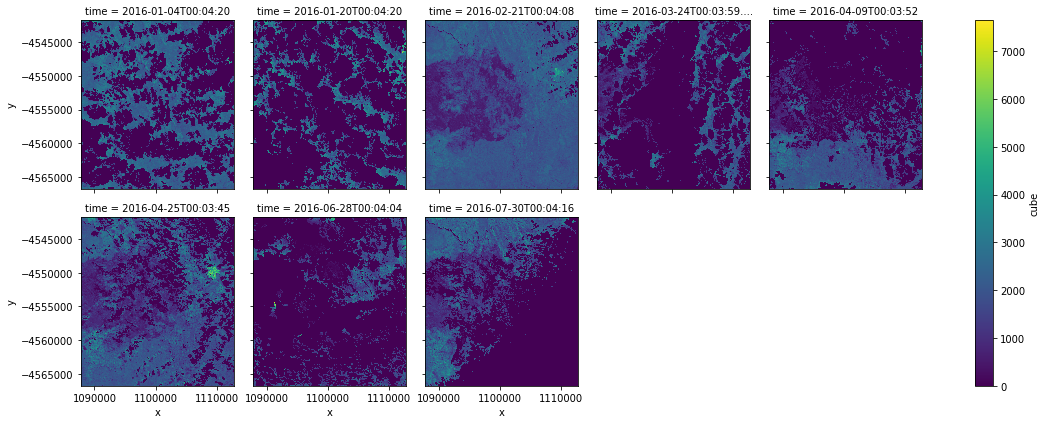

In [4]:
#plot NIR band 
bc.dataset.cube.sel(time=slice('2016-01-01','2016-08-01'))[3,:,:,:].plot.imshow(col='time',col_wrap = 5)

## Calculation of the Normalized Burn Ratio (NBR)
The Normalized Burn Ratio (NBR) is recommended for use in conjunction with the cosine distance to correctly identify significant reflectance changes that can be associated with fire events. 
NBR is calculated as:

$NBR = \frac{nir-swir2}{nir+swir2}$

where _nir_ and _swir2_ refer to the Near Infrared and Shortwave Infrared bands in the Landsat imagery.  

Some example NBR maps are shown below.

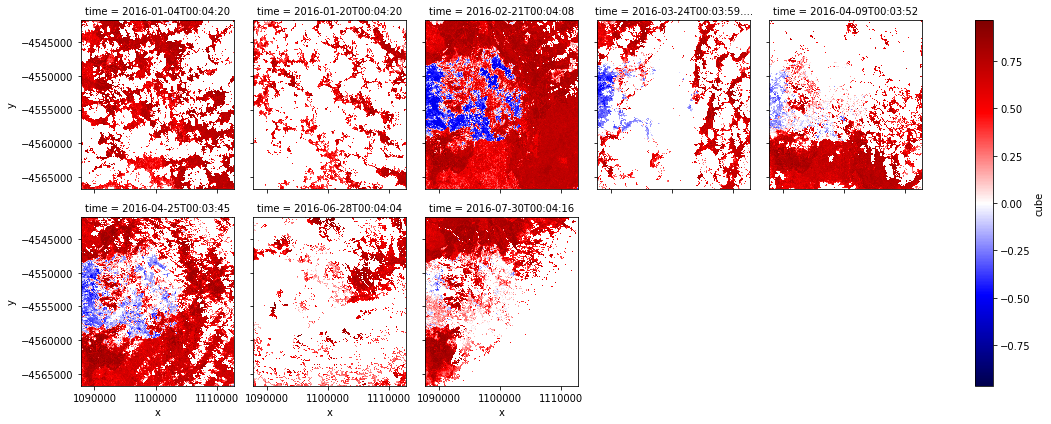

In [5]:
NBR = (bc.dataset.cube[3,:,:,:]-bc.dataset.cube[5,:,:,:])/(bc.dataset.cube[3,:,:,:]+bc.dataset.cube[5,:,:,:])
# plot NBR for the seleted period
NBR.sel(time=slice('2016-01-01','2016-08-01')).plot.imshow(col='time',col_wrap = 5,cmap='seismic')

## Calculation of geometric median  and cosine and euclidian distances

We will use the "geomedian" function in the BurnCube for the calculation of geometric median for the reference period. 

We will use the "distances" function in the BurnCube for the calculation of cosine distance and NBR ecuclidean distance.

The "geomedian" and "distances" function in default are distributed versions and can be run with the number of available CPUs to speed up the process. 

The functions calculate metrics defined as follows:

__geometric\_median__ returns the geometric median of band reflectances for the reflectance datacube provided:

$\hat{\mu}: = argmin\sum_{i=1}^{n}\parallel x-x_i\parallel$, $x\in \mathbb{R}^p$

The function involves an iterative optimiser to find a numerical solution. The optimisation can be configured by passing the maximum number of iterations and tolerance stopping criterion as arguments.   

__cosdistance__ returns the cosine distance between the reflectance time series data and the geometric median reflectance :

$cosdist = 1-\frac{\sum_{i=1}^{n}x_iy_i}{\sqrt{\sum_{i=1}^{n}x_i^2}\sum_{i=1}^{n}y_i^2}$

__nbr_eucdistance__ returns the euclidean distance between the NBR time series and the median NBR (_NBRmed_) calculated from the geometric median:

$NBRdist = \sqrt{\sum_{i=1}^{n}(NBR_i-NBRmed)^2}$

Use `help(function)` for  details on the usage of each function, as follows: 

In [6]:
help(bc.geomedian)
help(bc.distances)

Help on method geomedian in module BurnCube:

geomedian(period, n_procs=4, epsilon=0.5, max_iter=40) method of BurnCube.BurnCube instance

Help on method distances in module BurnCube:

distances(period, n_procs=4) method of BurnCube.BurnCube instance



### Geometric median
The following example shows the calculation of the geometric median using 8 processers

In [7]:
bc.geomedian(period, n_procs=8) # this normally takes 5mins for 1000x1000 area

In [8]:
bc.geomed.geomedian #the geomedian is stored in bc.geomed

<xarray.DataArray 'geomedian' (bands: 6, y: 1001, x: 1001)>
array([[[  351.245148,   336.97702 , ...,   315.750183,   352.187042],
        [  351.715515,   333.970337, ...,   322.082092,   327.114075],
        ..., 
        [  423.378174,   507.136292, ...,   234.895447,   243.381531],
        [  636.629456,   700.543518, ...,   242.687469,   238.172607]],

       [[  385.099487,   371.490082, ...,   331.30542 ,   363.726868],
        [  387.680481,   371.529327, ...,   333.894348,   344.554993],
        ..., 
        [  459.175018,   530.534363, ...,   281.019714,   308.425323],
        [  606.913879,   670.392029, ...,   304.079773,   309.100922]],

       ..., 
       [[ 1123.624512,  1080.123413, ...,  1056.62439 ,  1166.337646],
        [ 1115.098389,  1064.310913, ...,  1056.883789,  1098.249023],
        ..., 
        [ 1265.474609,  1555.043091, ...,   898.28656 ,   996.070129],
        [ 1905.809082,  2108.630859, ...,   993.636536,  1034.560547]],

       [[  523.892334,   48

#### Plotting functions
The following code generates an RGB composite with geometric median reflectances stretched between over the 99% inter-percentile range using the internal function `stretch_RGB`: 

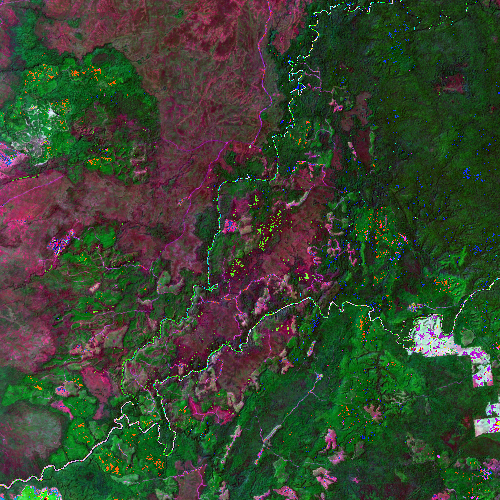

In [9]:
def stretch_RGB(data):
    """
    stretch RGB to 0-1
    """
    import numpy as np
    tmp = data
    a = (tmp-np.nanpercentile(tmp,1))/(np.nanpercentile(tmp,99.5)-np.nanpercentile(tmp,0.5))*255  
    return a
def RGB_plot(R, G, B):
    import numpy as np
    from PIL import Image,ImageEnhance    
    rgbArray = np.zeros((R.shape[0],R.shape[1],3), 'uint8')
    rgbArray[..., 0] = (stretch_RGB(R))
    rgbArray[..., 1] = (stretch_RGB(G))
    rgbArray[..., 2] = (stretch_RGB(B))
    img = Image.fromarray(rgbArray)
    return img.resize((500,500))

#plot the geometric median reflectances as false colour composite: swir2, nir and green as R,G,B
RGB_plot(bc.geomed.geomedian.data[5,:,:],bc.geomed.geomedian.data[3,:,:],bc.geomed.geomedian.data[1,:,:])


### Distances: cosine distance and euclidian distances
The following example shows the calculation of the distances together using 8 processers for the period used as reference

In [10]:
bc.distances(period, n_procs=8)

In [ ]:
bc.dists # all the distances together with NBR and change direction are stored in the bc.dists

<xarray.Dataset>
Dimensions:    (band: 6, time: 44, x: 1001, y: 1001)
Coordinates:
  * band       (band) <U5 'red' 'green' 'blue' 'nir' 'swir1' 'swir2'
  * time       (time) datetime64[ns] 2013-04-17T00:06:04 2013-06-20T00:06:10 ...
  * y          (y) float64 -4.567e+06 -4.567e+06 -4.567e+06 -4.567e+06 ...
  * x          (x) float64 1.088e+06 1.088e+06 1.088e+06 1.088e+06 1.088e+06 ...
    bands      (band) <U5 'red' 'green' 'blue' 'nir' 'swir1' 'swir2'
Data variables:
    cosdist    (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
    NBRDist    (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
    ChangeDir  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    NBR        (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577

## Mapping outlier threshold
Having calculated the cosine and NBR euclidian distance, we can calculate a distance _d_ for every pixel that corresponds to the threshold distance for an outlier. 
We the use quartile-based outlier criterion commonly used in box-and-whiskers plots, among others (Tukey, 1977): 

$ d > Q_{3}+1.5*{IQR} = Q_{3}+1.5(Q_{3}-Q_{1})$

where $Q_1$ and $Q_3$ are the 1st and 3rd quartile (or 25th and 75th percentile), and _IQR_ is the interquartile range.  


In [ ]:
# calculate the outliers for change detection 
bc.outliers()

The distance functions and outlier detection functions only need to be evaluated once for a given period and region of interest.The following example showed the threshold values for cosine distances and nbr_ecudistance

In [ ]:
bc.outlrs.CDistoutlier.plot.imshow(robust=True)

In [ ]:
bc.outlrs.NBRoutlier.plot.imshow(robust=True)

## Burn severity mapping

Before mapping the burn scar, the cosine distances and nbr_eucdistance have to be calculated for the mapping year. 

The function "severitymapping" from the BurnCube is designed to map the extent and severity of likely burns. Outputs include three class for the detected burnt area, namely, severe, medium and collaborate (hotspots data with 4km buffer)

Two methods are available for change and severity mapping using difference thresholding scheme, and are described and compared in the documentation:


1. "NBR": Cosine distance and dNBR<0. Suitable for burn detection.

2. "NBRdist": Cosine distance, NBR euclidean distance, and NBR change direction. Recommended for burn detection.

The default method is "NBRdist". "growing" is the region growing algorithm for mapping 'medium' burnt area.

The hotspot data is included as "collaborate" if data is avalable.

The following example shows generates a severity map for detected burns between Jan 2016 to Dec 2016 using method "NBR".

In [ ]:
bc.distances(mappingperiod,n_procs=8)
out = bc.severitymapping(mappingperiod, n_procs=8, method='NBR',growing=True) 

In [ ]:
#save the output in netCDF
out.to_netcdf('/g/data/xc0/project/Burn_Mapping/TestSites/BurnMapping_HowesValley_2018.nc')

In a following step, we plot the area detected as severe burnt, medium burnt and collaborated burnt. 

In [ ]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=[16,14])
out.Severe.plot.imshow(ax=axes[0][0],cmap='binary',add_colorbar=False)
out.Medium.plot.imshow(ax=axes[0][1],cmap='binary',add_colorbar=False)
out.Collaborate.plot.imshow(ax=axes[1][0],cmap='binary',add_colorbar=False)
Allburnt = out.Severe+out.Medium+out.Collaborate
from matplotlib.colors import ListedColormap
cMap = ListedColormap(['white','darksalmon','red','firebrick'])
Allburnt.plot.imshow(ax=axes[1][1],cmap=cMap,add_colorbar=True)

Validation example is included in the "Validation_example1.ipynb"